<a href="https://colab.research.google.com/github/Auhre/Ecommerce-Fraud-Detection/blob/main/Ecommerce_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ecommerce Fraud Detection with RNN together with GAN

[Ecommerce Dataset](https://www.kaggle.com/datasets/shriyashjagtap/fraudulent-e-commerce-transactions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv('fraud-ecomm.csv')
data

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,208.48,2024-01-12 23:39:55,PayPal,health & beauty,2,29,North Laurafort,desktop,27.245.104.92,USNV Griffin\nFPO AA 52700,USNV Griffin\nFPO AA 52700,0,149,23
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,231.57,2024-03-27 04:31:45,credit card,clothing,2,32,Burnsville,tablet,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, GA 68797","478 John Square Apt. 235\nMillerhaven, GA 68797",0,132,4
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,101.80,2024-01-31 23:51:42,bank transfer,electronics,4,36,Garciafort,mobile,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, OH ...","182 House Island Suite 198\nEast Scott, FM 84301",0,98,23
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,61.80,2024-01-12 16:21:32,bank transfer,electronics,5,34,Lake Josephberg,desktop,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...","27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...",0,191,16


In [3]:
class DataPreprocessor():
  def __init__(self, data):
    self.data = data
    self.target_col = None
    self.cleaned_data = None
    self.num_features_shape = None
    self.all_columns_list = None
    self.pipeline = None

  def reorder(self, data):
    cols = list(data.columns)
    cols.remove(self.target_col)
    cols.append(self.target_col)
    reordered_data = data[cols]
    return reordered_data

  def clean(self, droplist, target_col):
    self.data.drop(droplist, axis=1, inplace=True)
    self.target_col = target_col
    self.data.dropna(inplace=True)
    self.cleaned_data = self.reorder(self.data)
    return self.cleaned_data

  def sanity_check_clean(self):
    print('-------------------------------')
    print('Target Column Value Check:')
    print('-------------------------------')
    print(self.cleaned_data[self.target_col].value_counts())
    print('-------------------------------')
    print('Null Column Value Check:')
    print('-------------------------------')
    print(self.cleaned_data.isnull().sum())

  def fit_transform(self, data):
    data = self.reorder(data)
    categorical_features = data.select_dtypes(include=['object', 'boolean']).columns
    numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_data = data[categorical_features]
    numerical_data = data[numerical_features]
    self.num_features_shape = numerical_data.shape[1]
    self.all_columns_list = list(categorical_data.columns) + list(numerical_data.columns)
    preprocessor = ColumnTransformer(
        [
            ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('minmax', MinMaxScaler(), numerical_features)
        ],
        remainder='passthrough'
    )
    self.pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])
    self.pipeline.fit(data)
    transformed_data = self.pipeline.transform(data)
    return transformed_data

  def sanity_check_transform(self):
    print('-------------------------------')
    print('Order of Column Check:')
    print('-------------------------------')
    print(self.all_columns_list)

  def inverse_transform(self, data):
    column_transformer = self.pipeline.named_steps['preprocessor']
    num_transformer = column_transformer.named_transformers_['minmax']
    cat_transformer = column_transformer.named_transformers_['onehot']
    generated_num = num_transformer.inverse_transform(data[:, -self.num_features_shape:])
    generated_num[:, :-1] = np.round(generated_num[:, :-1])

    generated_num[generated_num[:, :] < 0] = 0

    generated_cat = cat_transformer.inverse_transform(data[:, 0: data.shape[1] - self.num_features_shape])
    combined_data = np.concatenate((generated_cat, generated_num), axis=1)

    df = pd.DataFrame(combined_data, columns=self.all_columns_list[:len(combined_data[0])])
    return combined_data, df

  def transform(self, data):
    transformed_data = self.pipeline.transform(data)
    return transformed_data

In [4]:
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])
data['Day of Week'] = data['Transaction Date'].dt.dayofweek
data['Day of Week'] = data['Day of Week'].astype(int)
data['Billing Shipping Address Match'] = data['Billing Address'] == data['Shipping Address']
data['Billing Shipping Address Match'] = data['Billing Shipping Address Match'].astype(int)

In [5]:
dp = DataPreprocessor(data)

In [6]:
cleaned_data = dp.clean(
    droplist=['Transaction ID', 'Customer ID', 'IP Address', 'Billing Address', 'Shipping Address', 'Customer Location', 'Transaction Date'],
    target_col='Is Fraudulent')
cleaned_data.head(15)

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Account Age Days,Transaction Hour,Day of Week,Billing Shipping Address Match,Is Fraudulent
0,58.09,bank transfer,electronics,1,17,tablet,30,5,1,1,0
1,389.96,debit card,electronics,2,40,desktop,72,8,6,1,0
2,134.19,PayPal,home & garden,2,22,tablet,63,3,0,1,0
3,226.17,bank transfer,clothing,5,31,desktop,124,20,5,1,0
4,121.53,bank transfer,clothing,2,51,tablet,158,5,0,1,0
5,166.41,bank transfer,toys & games,2,34,tablet,38,10,1,0,0
6,92.88,PayPal,toys & games,2,14,tablet,119,19,6,1,0
7,318.14,credit card,health & beauty,4,42,desktop,251,13,1,1,0
8,47.92,bank transfer,home & garden,4,38,desktop,190,19,6,1,0
9,121.78,bank transfer,health & beauty,4,39,mobile,343,21,1,1,0


In [7]:
dp.sanity_check_clean()

-------------------------------
Target Column Value Check:
-------------------------------
Is Fraudulent
0    1399114
1      73838
Name: count, dtype: int64
-------------------------------
Null Column Value Check:
-------------------------------
Transaction Amount                0
Payment Method                    0
Product Category                  0
Quantity                          0
Customer Age                      0
Device Used                       0
Account Age Days                  0
Transaction Hour                  0
Day of Week                       0
Billing Shipping Address Match    0
Is Fraudulent                     0
dtype: int64


In [8]:
transformed_data = dp.fit_transform(cleaned_data)
transformed_data

array([[0.        , 1.        , 0.        , ..., 0.16666667, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.33333333, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.66666667, 1.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [9]:
dp.sanity_check_transform()

-------------------------------
Order of Column Check:
-------------------------------
['Payment Method', 'Product Category', 'Device Used', 'Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour', 'Day of Week', 'Billing Shipping Address Match', 'Is Fraudulent']


In [10]:
quantity_index = len(cleaned_data['Payment Method'].unique()) + len(cleaned_data['Product Category'].unique()) + len(cleaned_data['Device Used'].unique()) + 1
quantity_index

13

# GAN

In [11]:
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, output_dim)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.tanh = nn.Tanh()
  def forward(self, z):
    x = self.leaky_relu(self.fc1(z))
    x = self.leaky_relu(self.fc2(x))
    x = self.tanh(self.fc3(x))
    return x

class Discriminator(nn.Module):
  def __init__(self, input_dim):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_dim, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 1)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()
  def forward(self, z):
    x = self.leaky_relu(self.fc1(z))
    x = self.leaky_relu(self.fc2(x))
    x = self.sigmoid(self.fc3(x))
    return x

In [12]:
class GAN():
  def __init__(self, input_dim, output_dim, latent_dim):
    self.generator = Generator(input_dim, output_dim)
    self.discriminator = Discriminator(output_dim)
    self.latent_dim = latent_dim

  def train(self, data, num_epochs=10, batch_size=64, lr=0.0002):
    criterion = nn.BCELoss()
    d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
    real_dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(num_epochs):
      for real_data in real_dataloader:
        real_data = real_data[0].clone().detach()
        z = torch.randn(batch_size, self.latent_dim)
        fake_data = self.generator(z)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        d_optimizer.zero_grad()
        real_output = self.discriminator(real_data)
        d_real_loss = criterion(real_output, real_labels)
        fake_output = self.discriminator(fake_data.detach())
        d_fake_loss = criterion(fake_output, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, self.latent_dim)
        fake_data = self.generator(z)
        fake_output = self.discriminator(fake_data)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()
      print(f'Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item()}, G_loss: {g_loss.item()}')

  def generate(self, num_samples=100):
    random_noise = torch.randn(num_samples, self.latent_dim)
    self.generator.eval()
    with torch.no_grad():
      synthetic_data = self.generator(random_noise)
    return synthetic_data

In [13]:
gan = GAN(input_dim=100, output_dim=transformed_data.shape[1], latent_dim=100)
gan.train(data=transformed_data, num_epochs=5, batch_size=64, lr=0.0001)

Epoch [1/5], D_loss: 0.5043119192123413, G_loss: 2.868283748626709
Epoch [2/5], D_loss: 0.2425341010093689, G_loss: 2.873304843902588
Epoch [3/5], D_loss: 0.22058767080307007, G_loss: 3.1556880474090576
Epoch [4/5], D_loss: 0.17013299465179443, G_loss: 3.9191462993621826
Epoch [5/5], D_loss: 0.09736201167106628, G_loss: 6.638923168182373


In [14]:
constructed_data = gan.generate(num_samples=3000000)
constructed_data

tensor([[ 9.9985e-01, -6.2994e-04,  4.9365e-03,  ...,  9.0006e-01,
          1.0000e+00,  2.3101e-04],
        [-1.2757e-03,  3.8694e-04,  1.0000e+00,  ...,  1.6803e-01,
          6.9238e-01, -1.1234e-03],
        [-7.0173e-04, -5.2500e-03,  1.0000e+00,  ...,  9.9025e-01,
          1.0000e+00, -1.1498e-02],
        ...,
        [ 1.1838e-03,  4.7599e-04,  9.9894e-01,  ...,  7.7878e-01,
          1.0000e+00, -4.6676e-04],
        [ 4.7760e-03,  8.0671e-04,  1.0000e+00,  ...,  9.7459e-01,
          1.0000e+00, -4.1377e-04],
        [ 1.2614e-04,  1.7973e-04,  1.0000e+00,  ...,  3.0783e-01,
          9.9843e-01,  7.6989e-04]])

In [15]:
constructed_data = constructed_data[constructed_data[:, quantity_index] > 0]
len(constructed_data)

2896111

In [16]:
class GANBinaryClassBalancer():
  def __init__(self, original_data, processed_data, synthetic_data, target_col):
    self.synthetic_data = synthetic_data
    self.processed_data = processed_data
    self.real_false_counts = original_data[target_col].value_counts()[0]
    self.real_true_counts = original_data[target_col].value_counts()[1]
    self.synthetic_data[:, -1] = torch.where(self.synthetic_data[:, -1] <= 0, torch.tensor(0), torch.tensor(1))
    self.class_balancer_num = None
    self.synthetic_true = None
    self.synthetic_false = None
    self.balancer_synthetic_data = None

  def balance_class(self, class_balancer_num):
    self.class_balancer_num = class_balancer_num
    self.synthetic_true = self.synthetic_data[self.synthetic_data[:, -1] == 1]
    self.synthetic_true = self.synthetic_true[:self.class_balancer_num - self.real_true_counts, :]
    self.synthetic_false = self.synthetic_data[self.synthetic_data[:, -1] == 0]
    self.synthetic_false = self.synthetic_false[:self.class_balancer_num - self.real_false_counts, :]
    self.balancer_synthetic_data = torch.cat((self.synthetic_true, self.synthetic_false), dim=0)
    extended_data = np.concatenate((self.processed_data, self.balancer_synthetic_data), axis=0)
    return extended_data

  def sanity_check(self):
    print('Completed balancing both classes with {0} entries'.format(self.class_balancer_num))
    print('Aditional synthetic true: {0}'.format(self.synthetic_true.shape[0]))
    print('Aditional synthetic false: {0}'.format(self.synthetic_false.shape[0]))
    print('Unique value check for synthetic true: {0}'.format(self.synthetic_true[:, -1].unique()))
    print('Unique value check for synthetic false: {0}'.format(self.synthetic_false[:, -1].unique()))

In [17]:
sb = GANBinaryClassBalancer(cleaned_data, transformed_data, constructed_data, 'Is Fraudulent')
transformed_balanced_fraud_dataset = sb.balance_class(1500000)
sb.sanity_check()

Completed balancing both classes with 1500000 entries
Aditional synthetic true: 1426162
Aditional synthetic false: 100886
Unique value check for synthetic true: tensor([1.])
Unique value check for synthetic false: tensor([0.])


In [18]:
transformed_balanced_fraud_dataset.shape

(3000000, 20)

In [19]:
extended_fraud_data, extended_fraud_df = dp.inverse_transform(transformed_balanced_fraud_dataset)
extended_fraud_df['Is Fraudulent'].value_counts()

,count
Is Fraudulent,
0.0,1500000
1.0,1500000


In [20]:
extended_fraud_df

,Payment Method,Product Category,Device Used,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of Week,Billing Shipping Address Match,Is Fraudulent
0,bank transfer,electronics,tablet,58.0,1.0,17.0,30.0,5.0,1.0,1.0,0.0
1,debit card,electronics,desktop,390.0,2.0,40.0,72.0,8.0,6.0,1.0,0.0
2,PayPal,home & garden,tablet,134.0,2.0,22.0,63.0,3.0,0.0,1.0,0.0
3,bank transfer,clothing,desktop,226.0,5.0,31.0,124.0,20.0,5.0,1.0,0.0
4,bank transfer,clothing,tablet,122.0,2.0,51.0,158.0,5.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2999995,credit card,home & garden,desktop,239.0,5.0,26.0,278.0,18.0,5.0,1.0,0.0
2999996,credit card,home & garden,mobile,0.0,1.0,27.0,324.0,1.0,3.0,1.0,0.0
2999997,PayPal,home & garden,desktop,0.0,5.0,32.0,210.0,13.0,1.0,0.0,0.0
2999998,credit card,home & garden,mobile,0.0,3.0,29.0,360.0,1.0,0.0,1.0,0.0


In [21]:
def plot_feature_distribution(df, col):
  plt.figure(figsize=(5, 5))
  sns.histplot(df[col], bins=40)
  plt.title('Distribution of {0} in the Extended Fraud Dataset by GAN'.format(col))
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.show()

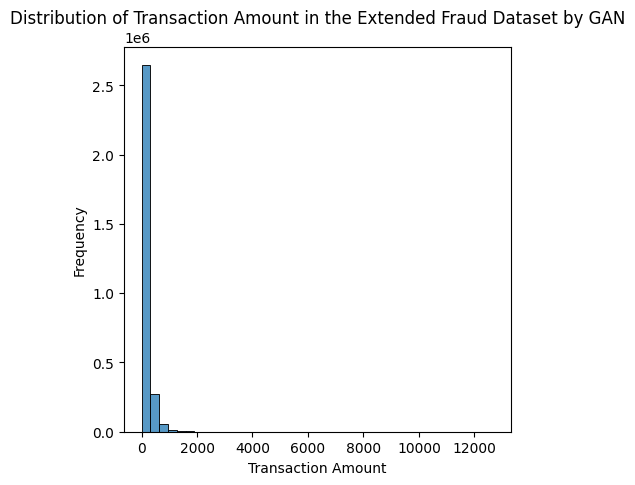

In [22]:
plot_feature_distribution(extended_fraud_df, 'Transaction Amount')

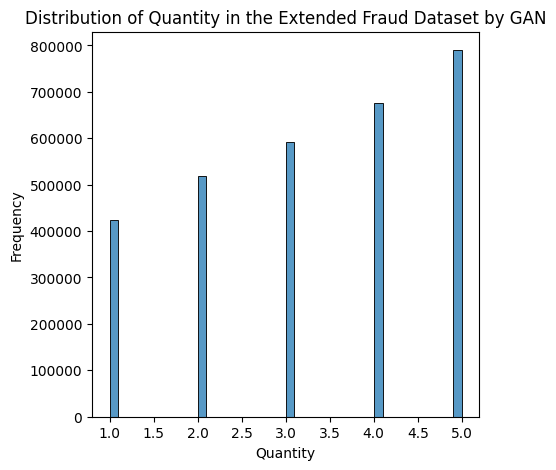

In [23]:
plot_feature_distribution(extended_fraud_df, 'Quantity')

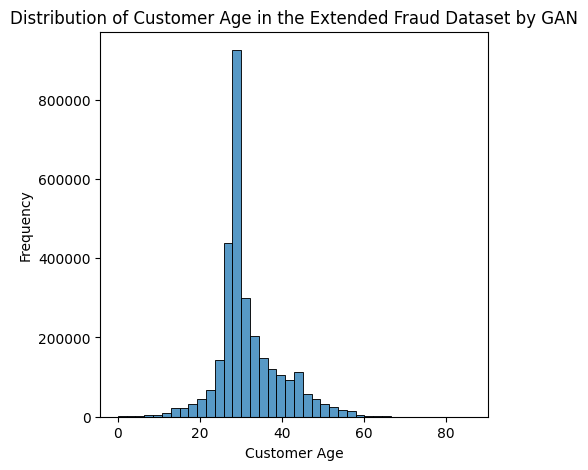

In [24]:
plot_feature_distribution(extended_fraud_df, 'Customer Age')

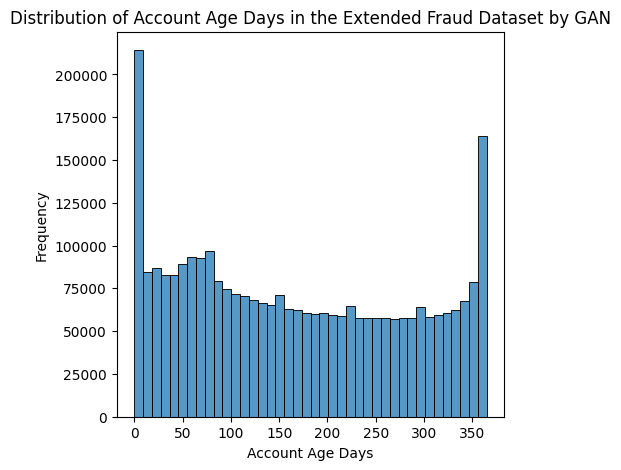

In [25]:
plot_feature_distribution(extended_fraud_df, 'Account Age Days')

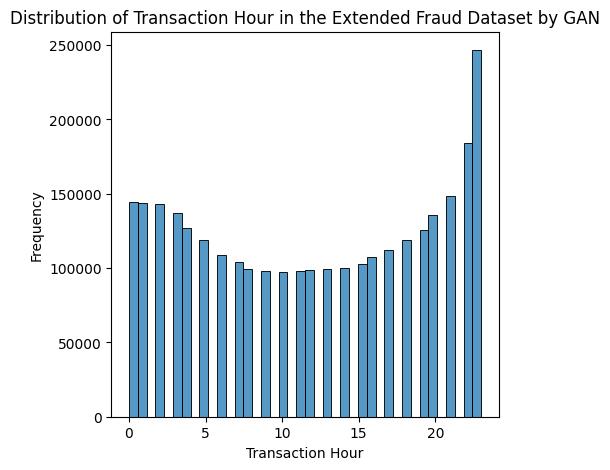

In [26]:
plot_feature_distribution(extended_fraud_df, 'Transaction Hour')

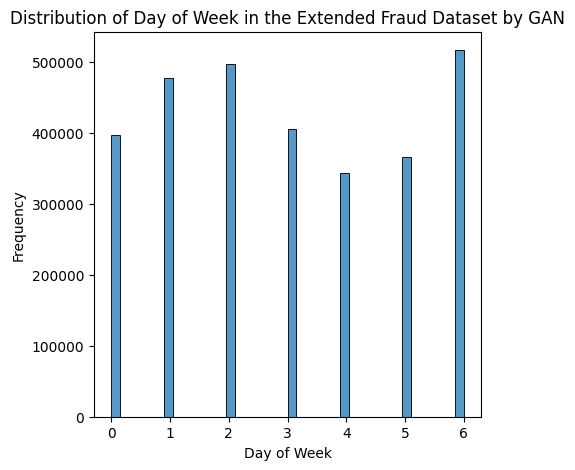

In [27]:
plot_feature_distribution(extended_fraud_df, 'Day of Week')

### LSTM for fraud detection


In [28]:
class FraudDetectionModel():
  def __init__(self, data):
    self.data = data
    self.X = None
    self.y = None
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test = None
    self.model = None
    self.history = None
    self.loss = None
    self.accuracy = None
    self.transformed_data = None

  def train_test_split(self, test_size=0.3, random_state=42):
    self.X = self.data[:, :-1]
    self.y = self.data[:, -1]
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)

  def build(self):
    self.model = Sequential()
    self.model.add(Input(shape=(self.X_train.shape[1], 1)))
    self.model.add(LSTM(64, return_sequences=True))
    self.model.add(Dropout(0.2))
    self.model.add(LSTM(64, return_sequences=False))
    self.model.add(Dropout(0.2))
    self.model.add(Dense(1, activation='sigmoid'))
    self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  def train(self, epochs=5, batch_size=64, validation_split=0.2):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    self.history = self.model.fit(self.X_train, self.y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stop])

  def plot_loss(self):
    plt.plot(self.history.history['loss'], label='Training Loss')
    plt.plot(self.history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  def evaluate(self):
    self.loss, self.accuracy = self.model.evaluate(self.X_test, self.y_test)
    print('Test Loss:', self.loss)
    print('Test Accuracy:', self.accuracy)

  def input_info(self, jsondata):
    print('-------------------------------')
    print('FEATURE INPUTS GUIDE')
    print('-------------------------------')
    print('Payment Method')
    print('-------------------------------')
    for e in jsondata['Payment Method']:
      print(e)
    print('-------------------------------')
    print('Product Category')
    print('-------------------------------')
    for e in jsondata['Product Category']:
      print(e)
    print('-------------------------------')
    print('Device Used')
    print('-------------------------------')
    for e in jsondata['Device Used']:
      print(e)
    print('-------------------------------')
    print('Billing Shipping Address Match')
    print('-------------------------------')
    for e in jsondata['Billing Shipping Address Match']:
      print(e)
    print('-------------------------------')
    print('Transaction Amount')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Transaction Amount'][0], jsondata['Transaction Amount'][1]))
    print('-------------------------------')
    print('Quantity')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Quantity'][0], jsondata['Quantity'][1]))
    print('-------------------------------')
    print('Customer Age')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Customer Age'][0], jsondata['Customer Age'][1]))
    print('-------------------------------')
    print('Account Age Days')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Account Age Days'][0], jsondata['Account Age Days'][1]))
    print('-------------------------------')
    print('Transaction Hour')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Transaction Hour'][0], jsondata['Transaction Hour'][1]))
    print('-------------------------------')
    print('Day of Week')
    print('-------------------------------')
    print('{0} - {1}'.format(jsondata['Day of Week'][0], jsondata['Day of Week'][1]))
    print('-------------------------------')

  def input_transformer(self, json_data, dp):
    data = pd.DataFrame([json_data])
    transformed_data = dp.transform(data)
    self.transformed_data = transformed_data[:, :-1]

  def input_predictor(self):
    prediction = self.model.predict(self.transformed_data)
    if prediction < 0.5:
      print('Transaction is likely to be legitimate, cool pal.')
    else:
      print('Transaction is likely to be fraudulent, kupal.')

  def metric_report(self):
    y_pred = (self.model.predict(self.X_test) > 0.5).astype(int)
    print('Classification Report:')
    print(classification_report(self.y_test, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(self.y_test, y_pred))

In [29]:
fd = FraudDetectionModel(data=transformed_balanced_fraud_dataset)

In [30]:
fd.train_test_split(test_size=0.2)

In [31]:
fd.build()

In [32]:
fd.train(epochs=10)

Epoch 1/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 965s 32ms/step - accuracy: 0.8831 - loss: 0.3062 - val_accuracy: 0.9395 - val_loss: 0.1832
Epoch 2/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 970s 32ms/step - accuracy: 0.9424 - loss: 0.1799 - val_accuracy: 0.9476 - val_loss: 0.1602
Epoch 3/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 983s 32ms/step - accuracy: 0.9481 - loss: 0.1619 - val_accuracy: 0.9512 - val_loss: 0.1516
Epoch 4/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 955s 32ms/step - accuracy: 0.9505 - loss: 0.1548 - val_accuracy: 0.9526 - val_loss: 0.1473
Epoch 5/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 961s 32ms/step - accuracy: 0.9517 - loss: 0.1508 - val_accuracy: 0.9525 - val_loss: 0.1478
Epoch 6/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 986s 32ms/step - accuracy: 0.9529 - loss: 0.1478 - val_accuracy: 0.9535 - val_loss: 0.1441
Epoch 7/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 985s 32ms/step - accuracy: 0.9534 - loss: 0.1458 - val_accuracy: 0.9527 - val_loss: 0.1468
Epoch 8/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 975s 32ms/s

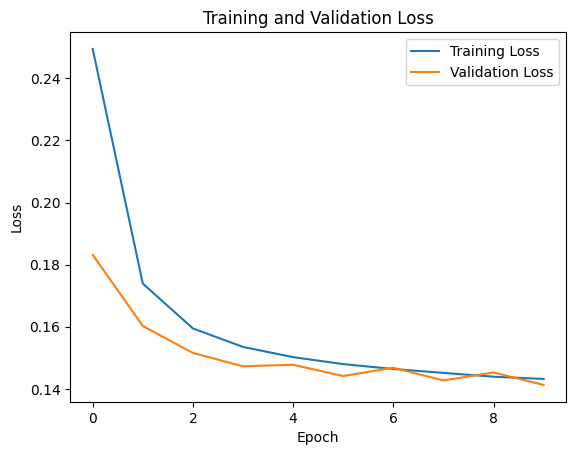

In [33]:
fd.plot_loss()

In [34]:
fd.evaluate()

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 152s 8ms/step - accuracy: 0.9551 - loss: 0.1396
Test Loss: 0.1398656666278839
Test Accuracy: 0.9549949765205383


In [35]:
fd.metric_report()

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 151s 8ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96    300206
         1.0       0.96      0.95      0.95    299794

    accuracy                           0.95    600000
   macro avg       0.95      0.95      0.95    600000
weighted avg       0.95      0.95      0.95    600000

Confusion Matrix:
[[287135  13071]
 [ 13932 285862]]


In [36]:
transaction_meta = {
    'Payment Method': extended_fraud_df['Payment Method'].unique(),
    'Product Category': extended_fraud_df['Product Category'].unique(),
    'Device Used': extended_fraud_df['Device Used'].unique(),
    'Billing Shipping Address Match': extended_fraud_df['Billing Shipping Address Match'].unique(),
    'Transaction Amount': [extended_fraud_df['Transaction Amount'].min(), extended_fraud_df['Transaction Amount'].max()],
    'Quantity': [extended_fraud_df['Quantity'].min(), extended_fraud_df['Quantity'].max()],
    'Customer Age': [extended_fraud_df['Customer Age'].min(), extended_fraud_df['Customer Age'].max()],
    'Account Age Days': [extended_fraud_df['Account Age Days'].min(), extended_fraud_df['Account Age Days'].max()],
    'Transaction Hour': [extended_fraud_df['Transaction Hour'].min(), extended_fraud_df['Transaction Hour'].max()],
    'Day of Week': [extended_fraud_df['Day of Week'].min(), extended_fraud_df['Day of Week'].max()],
    'Is Fraudulent': None
}

In [37]:
fd.input_info(transaction_meta)

-------------------------------
FEATURE INPUTS GUIDE
-------------------------------
Payment Method
-------------------------------
bank transfer
debit card
PayPal
credit card
-------------------------------
Product Category
-------------------------------
electronics
home & garden
clothing
toys & games
health & beauty
-------------------------------
Device Used
-------------------------------
tablet
desktop
mobile
-------------------------------
Billing Shipping Address Match
-------------------------------
1.0
0.0
-------------------------------
Transaction Amount
-------------------------------
0.0 - 12702.0
-------------------------------
Quantity
-------------------------------
1.0 - 5.0
-------------------------------
Customer Age
-------------------------------
0.0 - 86.0
-------------------------------
Account Age Days
-------------------------------
0.0 - 365.0
-------------------------------
Transaction Hour
-------------------------------
0.0 - 23.0
-------------------------

In [38]:
transaction_entry = {
    'Payment Method': 'bank transfer',
    'Product Category': 'electronics',
    'Device Used': 'tablet',
    'Billing Shipping Address Match': 0,
    'Transaction Amount': 1214,
    'Quantity': 3,
    'Customer Age': 19,
    'Account Age Days': 4,
    'Transaction Hour': 22,
    'Day of Week': 4,
    'Is Fraudulent': None
}

In [39]:
fd.input_transformer(transaction_entry, dp)

In [40]:
fd.input_predictor()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
Transaction is likely to be fraudulent, kupal.
